# Homework5 Approximation and Fitting

In [2]:
import cvxpy as cp
import numpy as np
from numpy.linalg import norm
from scipy.io import loadmat

## Fitting with uncensored data
The original problem is :  
$$\text{Minimize} \quad J=\sum_{k=1}^{K}(y^{(k)}-c^Tx^{(k)})^2$$
$y^{(1)},\ldots,y^{(M)}$ are known as certain values, but we only get the lower bound of $y^{(M+1)},\ldots,y^{(K)}$, which is $D$.  

The object is to find proper $c$ and $y^{(M+1)},\ldots,y^{(K)}$ that minimize $J$.

In [3]:
# load data from 'cens_fit_data_norng.m'
data = loadmat("data.mat")

n, M, K = data['n'][0][0], data['M'][0][0], data['K'][0][0] 
D = data['D'][0][0]
X = data['X']
c_true = data['c_true']
y = data['y']

### Take censored data into fitting
$$\text{Minimize} \quad \|y-c^TX_{[1:M]}\|_2^2 + \|y_{cen}-c^TX_{[M:K]}\|_2^2$$
$$\text{Subject to} \quad y_{cen} \succeq D$$

In [4]:
c = cp.Variable((n, 1))
y_cen = cp.Variable((K-M, 1))
obj = cp.Minimize(cp.sum_squares(y.T[0, :] - (c.T @ X)[0, :M]) + 
                  cp.sum_squares(y_cen.T[0, :] - (c.T @ X)[0, M:]))
cst = [y_cen >= D]
prob = cp.Problem(obj, cst)
prob.solve()

residual = norm(c_true - c.value, 2) / norm(c_true, 2)
print("Fitting with censored data, the residual is %.3f" % residual)

Fitting with censored data, the residual is 0.175


### Ignore the censored data
Only use the uncensored data samples: $y^{(1)},\ldots,y^{(M)}$.  
$$\text{Minimize} \quad \|y-c^TX_{[1:M]}\|_2^2 $$

In [5]:
# ignoring the censored data samples
c_ls = cp.Variable((n, 1))
obj_ls = cp.Minimize(cp.norm2(y.T[0, :] - (c_ls.T @ X)[0, :M]))
prob_ls = cp.Problem(obj_ls, None)

prob_ls.solve()
residual_ls = norm(c_ls.value - c_true, ord=2) / norm(c_true, ord=2)
print("Ignore the censored data, the residual is %.3f" % residual_ls)

Ignore the censored data, the residual is 0.366


### Alternate modeling
Instead of explicitly minimizing the censored prediction error $\|y_{cen}-D\|_2^2$, we can simply convert the object to a constraint:  

$$\text{Minimize} \quad \|y-c^TX_{[1:M]}\|_2$$
$$\text{Subject to} \quad c^TX_{[M:K]} \succeq D$$

In [6]:
c = cp.Variable((n, 1))
cst = [(c.T @ X)[0, M:] >= D]
obj = cp.Minimize(cp.norm2(y.T[0, :] - (c.T @ X)[0, :M]))

prob = cp.Problem(obj, cst)
prob.solve()

residual = norm(c.value - c_true, ord=2) / norm(c_true, ord=2)
print("Using the alternate modeling method, the residual is %.3f" % residual)

Using the alternate modeling method, the residual is 0.168


## Minimax rational fit to the exponential
Find a function:
$$f(t)=\frac{a_0 + a_1t + a_2t^2}{1 + b_1t + b_2t^2}$$
that minimize $max_{i=1,2,\ldots,k}|f(t_i)-e^{t_i}|$  
The generalized linear fractional function is quasiconvex, therefore we can use the bisection method to optimize it.

We can convert the quasiconvex program to convex program by giving a parameter $\gamma$.
$$\text{Minimize} \quad \gamma$$
$$\text{Subject to} \quad max_{i=1,\ldots,k}|\frac{t^Ta}{t^Tb}-y_i| \leq \gamma, t^Tb>0$$
while $t$ denote as $[1, t_i, t_i^2]$  
At last, the constraints are affine for $a$, $b$:  
(for all i)
1. $t^Tb \geq 0$
2. $|t^Ta - y_it^Tb| \leq \gamma t^Tb$

In [7]:
# generate data points
k = 201
t = np.linspace(-3, 3 + 0.03, k)
T = np.concatenate((np.ones((k, 1)), np.reshape(t, (k, 1)), np.reshape(t ** 2, (k, 1))), axis=1)
y = np.exp(t)

In [16]:
# construct the convex program
a = cp.Variable(3)
b = cp.hstack((1, cp.Variable(2)))
gamma = cp.Parameter(nonneg=True)

cst = [T @ b >= 0, cp.abs(T @ a - cp.multiply(y, T @ b)) <= gamma * T @ b]
obj = cp.Minimize(0)
prob = cp.Problem(obj, cst)

In [21]:
# recursive bisection, the lower_bound of gamma -> infeasible, the upper_bound of gamma -> optimal
def bisection(lower_bound:float, upper_bound:float)->float:
    assert upper_bound >= lower_bound
    global gamma
    gamma.value = (lower_bound + upper_bound) / 2
    if (upper_bound - lower_bound) < 0.001:
        return gamma.value

    prob.solve()

    if prob.status == 'infeasible':
        return bisection(gamma.value, upper_bound)
    else:
        return bisection(lower_bound, gamma.value)

In [22]:
value = bisection(lower_bound=0, upper_bound=10)
print("the optimal value is %.4f" % value)
print("a0=%.4f, a1=%.4f, a2=%.4f" % (a[0].value, a[1].value, a[2].value))
print("b1=%.4f, b2=%.4f" % (b[1].value, b[2].value))

the optimal value is 0.0235
a0=1.0095, a1=0.6158, a2=0.1149
b1=-0.4126, b2=0.0480


### plot the exponential curve and linear fractional function

In [23]:
from matplotlib import pyplot as plt

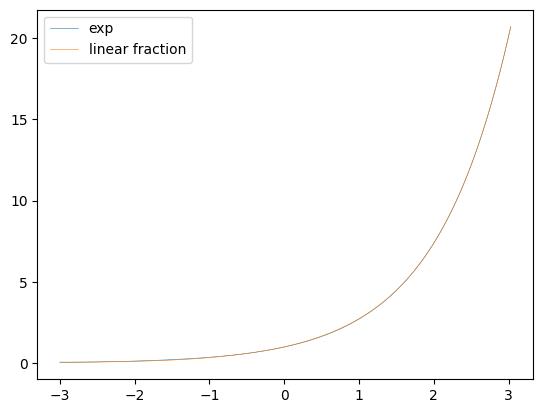

In [27]:
linfrac = a[0].value + a[1].value * t + a[2].value * t**2
linfrac = np.divide(linfrac, 1 + b[1].value * t + b[2].value * t**2)
plt.plot(t, y, t, linfrac, linewidth=0.4)
plt.legend(['exp', 'linear fraction'])
plt.show()